# Exploratory analysis

## Looking at our data

In [1]:
import torch
from node2vec import Node2Vec
from torch_geometric.data import Data
from utils.gsn_argparse import str2bool, str2actication
import torch_geometric.utils as gutils
from torch_geometric.nn import GAE
import trainer
import utils.gsn_argparse as gap
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Label encoding

In [32]:
# Read data and make dataframes
name = ['entity', 'id']
entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=name, engine='python')
entity = entity_id['entity'].values

name = ['relation', 'id']
relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=name, engine='python')
relation = relation_id['relation'].values

# Read RDF Triples
name = ['subject', 'object', 'relation']
data = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=name, engine='python')

SUBSAMPLE = 100

subjects = data['subject'].values[:SUBSAMPLE]
objects = data['object'].values[:SUBSAMPLE]
relations = data['relation'].values[:SUBSAMPLE]

In [33]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# fit entity encoder
le_entity = LabelEncoder()
le_entity.fit(entity)

# fit relationship encoder
le_relation = OneHotEncoder()
le_relation.fit(relations.reshape(-1, 1))

# string list to int array using LabelEncoder on complete data set
subjects = le_entity.transform(subjects)
objects = le_entity.transform(objects)
relations = le_relation.transform(relations.reshape(-1, 1)).todense()

In [110]:
relations[[54,21,31,23]]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0

In [100]:
a = torch.tensor(relations[0])
b = torch.tensor(relations[1])

print(b, a)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)


In [102]:
a = torch.cat((a, b), dim=0)
print(a)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)


In [ ]:
torch

In [77]:
# encode subsample (change range to 0-N)
le_entity2 = LabelEncoder().fit(np.append(subjects,objects))

subjects = le_entity2.transform(subjects)
objects = le_entity2.transform(objects)

In [38]:
y = torch.tensor(relations, dtype=torch.float)
edge_index = torch.tensor([subjects, objects], dtype=torch.long)
unique_entities = torch.tensor(np.unique(edge_index.reshape(edge_index.shape[-1]*2, 1)), dtype=torch.float)

dataset = Data(x=unique_entities,edge_attr=y, edge_index=edge_index)

In [39]:
dataset

Data(edge_attr=[100, 71], edge_index=[2, 100], x=[191])

In [2]:
# Read data and make dataframes
name = ['entity', 'id']
entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=name, engine='python')
entity = entity_id['entity'].values

name = ['relation', 'id']
relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=name, engine='python')
relation = relation_id['relation'].values

# Read RDF Triples
name = ['subject', 'object', 'relation']
data = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=name, engine='python')

from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
import numpy as np

def label_encode_dataset(all_entities, all_relations, dataset):
    subjects = data['subject'].values
    objects = data['object'].values
    relations = data['relation'].values
    
    # fit entity encoder
    le_entity = LabelEncoder()
    le_entity.fit(entity)

    # fit relationship encoder
    le_relation = LabelEncoder()
    le_relation.fit(relation)

    # string list to int array using LabelEncoder on complete data set
    subjects = le_entity.transform(subjects)
    objects = le_entity.transform(objects)
    relations = le_relation.transform(relations)
    
    # encode subsample (change range to 0-N)
    le_entity2 = LabelEncoder().fit(np.append(subjects,objects))
    le_relation2 = LabelEncoder().fit(relations)

    subjects = le_entity2.transform(subjects)
    objects = le_entity2.transform(objects)
    relations = le_relation2.transform(relations)
    
    edge_attributes = torch.tensor(relations, dtype=torch.float)
    edge_index = torch.tensor([subjects, objects], dtype=torch.long)
    unique_entities = torch.tensor(np.unique(edge_index.reshape(edge_index.shape[-1]*2, 1)), dtype=torch.float)

    return Data(x=unique_entities, edge_attr=edge_attributes, edge_index=edge_index)

dataset = label_encode_dataset(entity, relation, data)

In [4]:
dataset.edge_attr

tensor([341., 526.,  54.,  ..., 315.,  36., 568.])

In [40]:
label_dict ={}
for n1, n2, ys in zip(subjects, objects, y):
    label_dict[int(n1), int(n2)] = int(ys)

ValueError: only one element tensors can be converted to Python scalars

In [41]:
def visualize(h, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=True,
                          cmap="Set2")
        nx.draw_networkx_edge_labels(h, pos=nx.spring_layout(h, seed=42), edge_labels=label_dict, cmap="Set2")
    plt.show()

In [42]:
from torch_geometric.utils import to_networkx
G = to_networkx(dataset)

In [43]:
print(G.number_of_nodes())
print(dataset.num_nodes)

191
191


<IPython.core.display.Javascript object>


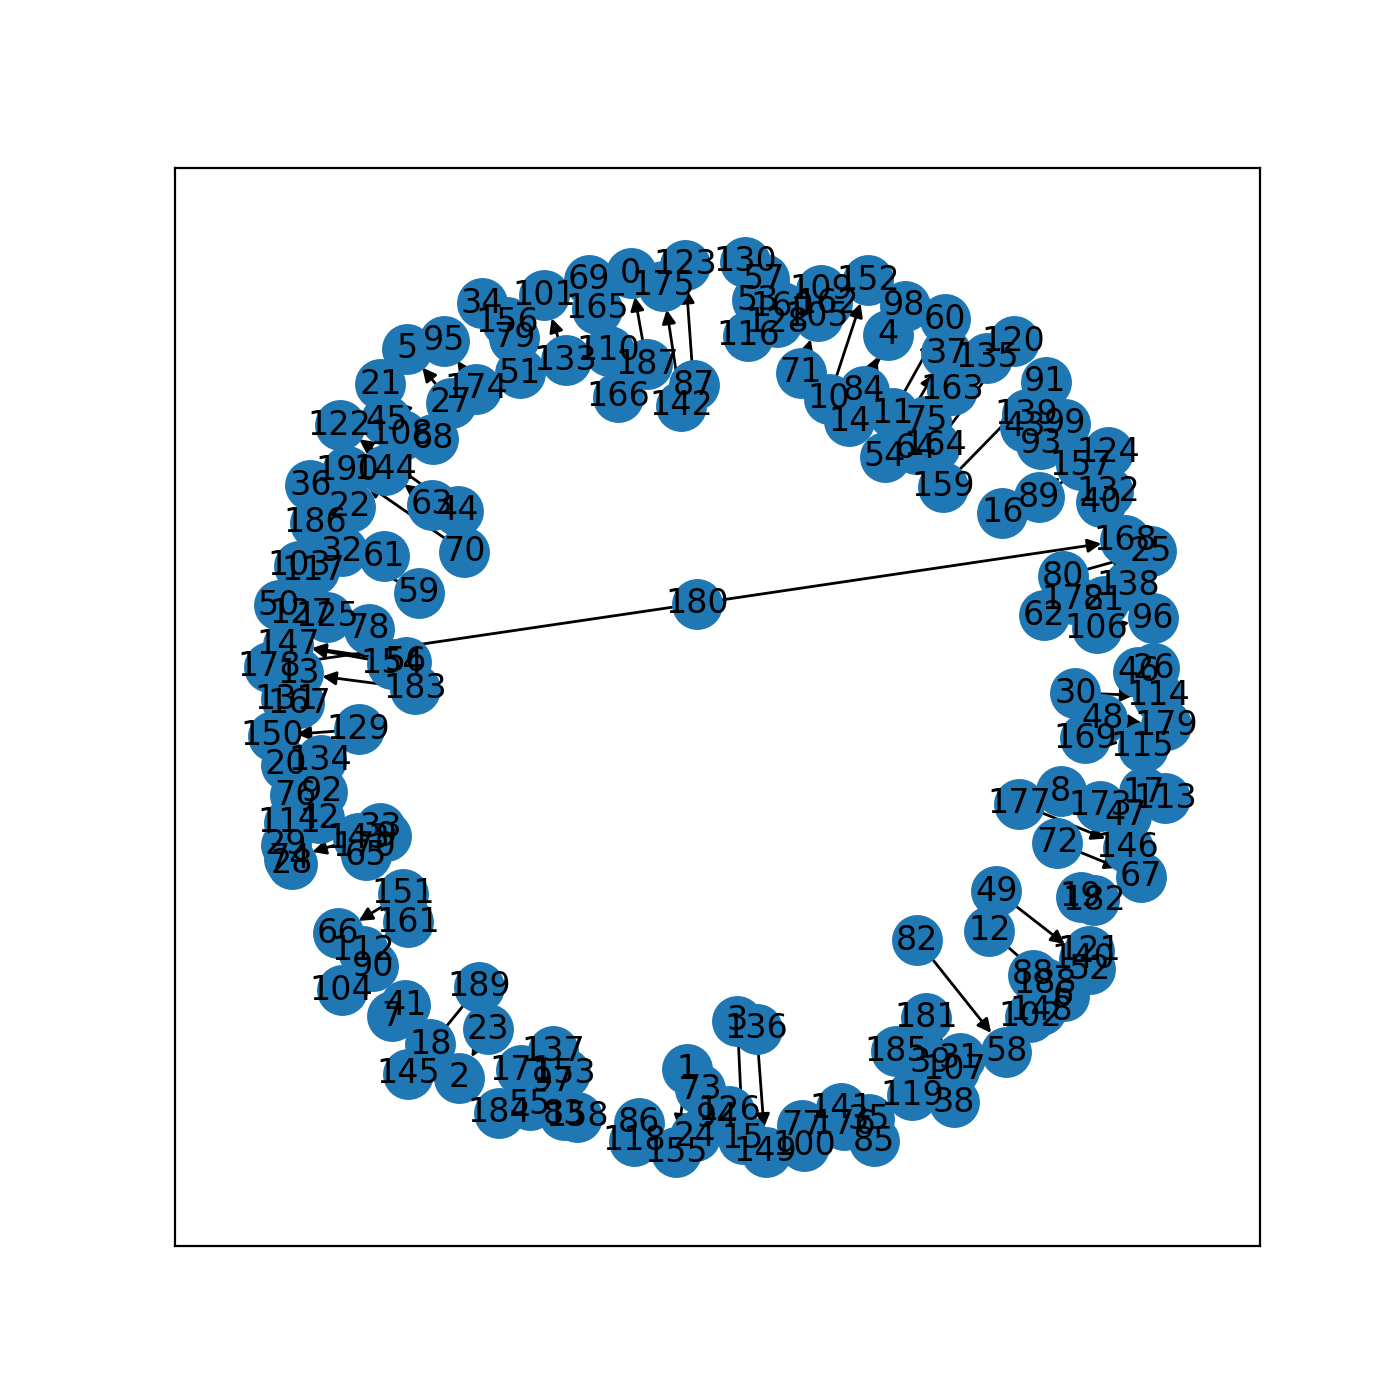

In [44]:
%matplotlib notebook
if len(unique_entities) > 200:
    print("you should probably not visualize huge node networks")
else:
    visualize(G) 

In [358]:
def inverse_transform(sub, obj, rel):
    sub = le_entity.inverse_transform(le_entity2.inverse_transform([sub]))
    obj = le_entity.inverse_transform(le_entity2.inverse_transform([obj]))
    rel = le_relation.inverse_transform(le_relation2.inverse_transform([rel]))
    return sub[0], obj[0], rel[0]

In [359]:
#!pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def freebase_parser(freebase_id):
    endpoint_url = "https://query.wikidata.org/sparql"

    query = \
    '''SELECT ?sLabel WHERE { 
        ?s wdt:P646 "''' + freebase_id + '''".
        SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 1'''
    res = get_results(endpoint_url, query)
    if len(res['results']['bindings']) == 0:
        return "No result"
    else:
        return get_results(endpoint_url, query)['results']['bindings'][0]['sLabel']['value']

In [360]:
def rdf2txt(sub, obj, rel):
    sub, obj, rel = inverse_transform(sub,obj,rel)
    sub = freebase_parser(sub)
    obj = freebase_parser(obj)
    return sub, obj, str(rel)

In [361]:
rdf2txt(23, 2, 46)

('country music', 'Donna Summer', '/music/genre/artists')

## Node2Vec

In [362]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=16, walk_length=15, num_walks=20, workers=1)  # Use temp_folder for big graphs

Generating walks (CPU: 1): 100%|███████████████████████████████████| 20/20 [01:24<00:00,  4.23s/it]


In [363]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  
# Any keywords acceptable by gensim.Word2Vec can be passed, 
# `dimensions` and `workers` are automatically passed
# (from the Node2Vec constructor)

In [364]:
def node2Text(node_id):
    freebase_id = le_entity.inverse_transform(le_entity2.inverse_transform([node_id]))
    return freebase_parser(freebase_id[0])

In [365]:
# Look for most similar nodes
NODE_ID = '2'
print(f"Most similar Nodes to {node2Text(int(NODE_ID))}")
for node in model.wv.most_similar(NODE_ID):
    sim_node_id, percentage = node
    print(node2Text(int(sim_node_id)), percentage) 

Most similar Nodes to Donna Summer


ValueError: y contains previously unseen labels: [2934]

In [370]:
# Save embeddings for later use
import os
PATH = 'embeddings'
NODE_EMBEDDING_NAME = "node_embedding"
EMBEDDING_MODEL_NAME = "node_embedding_model"
if not os.path.exists(PATH):
    os.mkdir(PATH)
model.wv.save_word2vec_format(os.path.join(PATH, NODE_EMBEDDING_NAME + ".kv"))

In [367]:
# Save model for later use
model.save(os.path.join(PATH, EMBEDDING_MODEL_NAME + ".pkl"))

In [373]:
from gensim.models import KeyedVectors
embedded_nodes =  KeyedVectors.load_word2vec_format('embeddings/node_embedding.kv')


In [371]:
# Load embeddings 
embeddings = model.wv.load_word2vec_format(os.path.join(PATH, NODE_EMBEDDING_NAME + ".kv"))
embedded_model = model.wv.load(os.path.join(PATH, EMBEDDING_MODEL_NAME + ".pkl"))

In [300]:
# Look for most similar nodes
NODE_ID = '2'
print(f"Most similar Nodes to {node2Text(int(NODE_ID))}")
for node in embedded_model.wv.most_similar(NODE_ID):
    sim_node_id, percentage = node
    print(node2Text(int(sim_node_id)), percentage) 

Most similar Nodes to Lubbock
Haverhill 0.9692298173904419
Lima 0.9591391086578369
Washoe County 0.9576570987701416
Kane County 0.955715537071228
Lake County 0.949510931968689
Norristown 0.9478277564048767
Longview 0.9473991990089417
Gatineau 0.9460849165916443
Richmond 0.9453619718551636
Lake County 0.9439355134963989


In [508]:
embedded_x = torch.tensor(embeddings.vectors, dtype=torch.float)

In [517]:
dataset.edge_index = torch.stack([row, col], dim=0)

In [429]:
data = GAE.split_edges(GAE, dataset)

In [430]:
l1 = data.test_pos_edge_index[0][0]
l2 = data.test_pos_edge_index[1][0]

In [450]:
print(dataset.edge_index[0].tolist().index(l1))
print(dataset.edge_index[1].tolist().index(l2))

10772
1436


In [510]:
dataset

Data(edge_index=[2, 50000], x=[13292], y=[50000])

In [548]:
y[np.where(dataset.edge_index.T == torch.tensor([5217, 10644]))[0]]

tensor([354.,  54., 358., 315.,  36.,  37., 283., 283.,  36., 536., 867.,  46.])

In [516]:
import math as m

entity_id = pd.read_csv('./data/FB15k/entities.txt', sep='\t', header=None, names=['entity', 'id'], engine='python')
entity = entity_id['entity'].values

relation_id = pd.read_csv('./data/FB15k/relations.txt', sep='\t', header=None, names=['relation', 'id'], engine='python')
relation = relation_id['relation'].values

data = pd.read_csv('./data/FB15k/valid.txt', sep='\t', header=None, names=['subject', 'object', 'relation'], engine='python')
print('\tLoading FB15k training (valid file) data...')

dataset = label_encode_dataset(entity, relation, data)

# create node embeddings if none exists
if not os.path.exists("embeddings"):
    create_node_embedding(dataset)
embedded_nodes =  KeyedVectors.load_word2vec_format('embeddings/node_embedding.kv')

dataset.x = torch.tensor(embedded_nodes.vectors, dtype=torch.float)
data = GAE.split_edges(GAE, dataset)

	Loading FB15k training (valid file) data...


In [484]:
print(dataset)
full_length = dataset.edge_index.shape[-1]
train_index = torch.tensor(dataset.edge_index[:, 0:m.floor(full_length*0.7)], dtype=torch.long)
train_attr_index = torch.tensor(dataset.edge_attr[0:m.floor(full_length*0.7)], dtype=torch.long)

val_index = torch.tensor(dataset.edge_index[:, m.floor(full_length*0.7):m.floor(full_length*0.9)], dtype=torch.long)
val_attr_index = torch.tensor(dataset.edge_attr[m.floor(full_length*0.7):m.floor(full_length*0.9)], dtype=torch.long)

test_index = torch.tensor(dataset.edge_index[:, m.floor(full_length*0.9):], dtype=torch.long)
test_attr_index = torch.tensor(dataset.edge_attr[m.floor(full_length*0.9):], dtype=torch.long)



dataset.edge_index = torch.cat([train_index, val_index, test_index], dim=1)
dataset.edge_attr = torch.cat([train_attr_index, val_attr_index, test_attr_index])

dataset.edge_train_mask = torch.cat([torch.ones((train_index.size(-1))),
                                  torch.zeros((val_index.size(-1))),
                                  torch.zeros((test_index.size(-1)))], dim=0).byte()
dataset.edge_val_mask = torch.cat([torch.zeros((train_index.size(-1))),
                                torch.ones((val_index.size(-1))),
                                torch.zeros((test_index.size(-1)))], dim=0).byte()
dataset.edge_test_mask = torch.cat([torch.zeros((train_index.size(-1))),
                                 torch.zeros((val_index.size(-1))),
                                 torch.ones((test_index.size(-1)))], dim=0).byte()

dataset.edge_train_attr_mask = torch.cat([torch.ones((train_attr_index.size(-1))),
                                  torch.zeros((val_attr_index.size(-1))),
                                  torch.zeros((test_attr_index.size(-1)))], dim=0).byte()
dataset.edge_val_attr_mask = torch.cat([torch.zeros((train_attr_index.size(-1))),
                                torch.ones((val_attr_index.size(-1))),
                                torch.zeros((test_attr_index.size(-1)))], dim=0).byte()
dataset.edge_test_attr_mask = torch.cat([torch.zeros((train_attr_index.size(-1))),
                                 torch.zeros((val_attr_index.size(-1))),
                                 torch.ones((test_attr_index.size(-1)))], dim=0).byte()

dataset.edge_type = torch.zeros(((dataset.edge_index.size(-1)),)).long()

dataset.batch = torch.zeros((1, dataset.num_nodes), dtype=torch.int64).view(-1)
dataset.num_graphs = 1
num_features = dataset.x.shape[-1] 
num_relations = max(np.unique(dataset.edge_attr)) + 1

Data(batch=[13292], edge_attr=[50000], edge_index=[2, 50000], edge_test_attr_mask=[50000], edge_test_mask=[50000], edge_train_attr_mask=[50000], edge_train_mask=[50000], edge_type=[50000], edge_val_attr_mask=[50000], edge_val_mask=[50000], num_graphs=[1], x=[13292, 16])

In [538]:
np.where(dataset.edge_index.T == data.val_pos_edge_index.T[0])[0]

array([ 3418,  5845, 11644, 11644, 13599, 16323, 17109], dtype=int64)

In [547]:
pair = dataset.val_pos_edge_index.T[0]
obj = pair[1]
sub = pair[0]
rel = np.where(dataset.edge_index.T == data.val_pos_edge_index.T[0])[0]
print(obj, sub, rel)

tensor(11883) tensor(5787) [ 3418  5845 11644 11644 13599 16323 17109]


In [546]:
rdf2txt(int(sub), int(obj), int(y[rel]))

('Keith Carradine',
 'Nashville',
 '/film/film/release_date_s./film/film_regional_release_date/film_release_distribution_medium')

In [513]:
dataset.edge_attr[4877]

tensor(898.)

In [330]:
rdf2txt(8937, 4141, 341)

('American Pie', 'romance film', '/film/film/genre')

In [ ]:
from torch_geometric.utils import to_networkx
from node2vec import Node2Vec
import os

def make_node_embeddings(dataset, path="embeddings", node_embedding_name="node_embeddings", embedding_model_name="node_embedding_model", dimensions=16, walk_length=15, num_walks=20, workers=1, window=10, min_count=1, batch_words=4):
    G = to_networkx(dataset)
   
    # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)  # Use temp_folder for big graphs
    
    # Embed nodes
    model = node2vec.fit(window=window, min_count=min_count, batch_words=batch_words)  # Any keywords acceptable by gensim.Word2Vec can be passed, 
                                                                 # `dimensions` and `workers` are automatically passed
                                                                 # (from the Node2Vec constructor)
    
    # Save embeddings for later use
    if not os.path.exists(path):
        os.mkdir(path)
    model.wv.save_word2vec_format(os.path.join(path, node_embedding_name + ".kv"))
    model.save(os.path.join(path, embedding_model_name + ".pkl"))
    print(f"Saved embedding and model in the {path} folder")
    return model.vw.vectors

## Evaluating Graph Star Multi Relational

In [217]:
model = torch.load("output/FB15K.pkl")

In [16]:
model.link_prediction

True

In [17]:
model.training

False

In [18]:
edge_index = torch.tensor([[0],[10505]], dtype=torch.long)
x = torch.tensor([[10039, 4677],[9561,4397], [11924,  6872],[12966, 12859]], dtype=torch.float)
batch = torch.zeros((1, len(x)), dtype=torch.int64).view(-1)
star_seed = None
edge_type = torch.zeros(((edge_index.size(-1)),)).long()

In [19]:
 logits_node, logits_star, logits_lp = model(x, edge_index, batch, star=star_seed, edge_type=edge_type)

IndexError: index out of range in self

In [20]:
x = torch.tensor([[10039, 4677],[9561,4397], [11924,  6872],[12966, 12859]], dtype=torch.float)


In [21]:
y = model.fl(x)

In [22]:
y[0].argmax(), y[1].argmax(), y[2].argmax(), y[3].argmax(), 

(tensor(105), tensor(105), tensor(105), tensor(105))

In [23]:
len(y[0])

512